In [1]:
import requests
import datetime as dt # 時間套件
import pandas as pd
from dateutil.relativedelta import relativedelta

def Get_N_Month_Data(month_num:int,stock_id:int) ->pd.DataFrame:
# 當日時間
    date_now = dt.datetime.now()

    # 建立日期串列
    date_list = [(date_now - relativedelta(months=i)).replace(day=1).\
                strftime('%Y%m%d') for i in range(month_num)]
    date_list.reverse()

    # 用於存儲每個月的數據
    all_data = []

    # 使用迴圈抓取連續月份資料
    for date in date_list:
        url = f'https://www.twse.com.tw/rwd/zh/afterTrading/\
            STOCK_DAY?date={date}&stockNo={stock_id}'
        try:
            json_data = requests.get(url).json()

            df = pd.DataFrame(data=json_data['data'],
                            columns=json_data['fields'])
        
            all_data.append(df)

        except Exception as e:
            print(f"無法取得{date}的資料, 可能資料量不足.")

    # 合併所有月份的數據
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    return final_df
    
def Get_Data_Dict(data:pd.DataFrame)->dict:
    
    try:
        if not data.empty: 
            columns_list = data.columns.tolist()
            datas_list = data.values.tolist()

            final_dict_list = []
            for row in datas_list:
                row_dict = {columns_list[i]: row[i] for i in range(len(columns_list))}
                final_dict_list.append(row_dict)
        
            return final_dict_list
        else:
            print("資料遺失或空白 DataFrame")
            return {}
    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        return {}

In [16]:
from pydantic import BaseModel,RootModel,Field
from datetime import datetime

class StockData(BaseModel):
    date:datetime=Field(alias="日期")
    trading_volume:str=Field(alias="成交股數")
    turnover:str=Field(alias="成交金額")
    open_price:float=Field(alias="開盤價")
    high_price:float=Field(alias="最高價")
    low_price:float=Field(alias="最低價")
    close_price:float=Field(alias="收盤價")
    change:float=Field(alias="漲跌價差")
    transactions:str=Field(alias="成交筆數")

class Data(RootModel):
    root:list[StockData]

def parse_custom_date(date_str):
    year = int(date_str[:3]) + 1911  # 将 "113" 转换为四位数的年份
    month = int(date_str[4:6])       # 月份
    day = int(date_str[7:9])         # 日
    
    return datetime(year, month, day)

In [19]:
def Calculate_Moving_Average(data: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
    # 将日期列转换为日期时间格式
    # 按日期排序（如果未排序的话）
    data = data.sort_values(by='日期')

    # 计算收盘价的移动平均
    data['SMA'] = data['收盤價'].rolling(window=window_size).mean()

    return data


In [22]:

def main():
    month_num=6
    stock_id=1101
    month_datas:pd.DataFrame=Get_N_Month_Data(month_num=month_num,stock_id=stock_id)
    month_datas['日期'] = month_datas['日期'].apply(parse_custom_date)
    data_list:list=Get_Data_Dict(month_datas)
    data:Data=Data.model_validate(data_list)
    stock_datas:list[dict]=data.model_dump()

    window_size=10
    moving_avg_data = Calculate_Moving_Average(month_datas, window_size=window_size)
    print(moving_avg_data)

# 打印移动平均数据
    # print(moving_avg_data[['日期', 'close_price', 'SMA']])
    
if __name__ =="__main__":
    main()

            日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0   2024-01-02  14,937,049    518,751,792  34.85  34.85  34.60  34.70  -0.15   
1   2024-01-03  12,793,849    438,994,226  34.50  34.75  34.15  34.20  -0.50   
2   2024-01-04   6,473,946    221,350,197  34.20  34.30  34.15  34.20   0.00   
3   2024-01-05   4,691,751    160,866,951  34.20  34.35  34.20  34.35  +0.15   
4   2024-01-08   5,581,614    191,844,472  34.40  34.55  34.25  34.25  -0.10   
..         ...         ...            ...    ...    ...    ...    ...    ...   
107 2024-06-17  13,657,934    463,303,134  34.00  34.15  33.80  34.00   0.00   
108 2024-06-18  10,652,577    360,223,401  34.00  34.05  33.70  33.90  -0.10   
109 2024-06-19  18,212,141    619,087,320  33.90  34.10  33.80  34.05  +0.15   
110 2024-06-20  12,859,180    438,336,654  34.05  34.15  34.00  34.15  +0.10   
111 2024-06-21  34,661,381  1,196,685,878  34.15  34.70  34.10  34.65  +0.50   

       成交筆數     SMA  
0     4,172     N

In [48]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

data = pd.read_csv('data.csv')

print(data)



          Date   Open   High    Low  Close   Adj Close    Volume       sma  \
0   2023-12-01  573.0  579.0  573.0  579.0  571.105164  28051165  580.1905   
1   2023-12-04  582.0  582.0  571.0  574.0  566.173340  26847171  580.1905   
2   2023-12-05  571.0  572.0  567.0  570.0  562.227905  22229723  580.1905   
3   2023-12-06  568.0  575.0  568.0  570.0  562.227905  21518089  580.1905   
4   2023-12-07  570.0  573.0  566.0  566.0  558.282410  20840397  580.1905   
5   2023-12-08  574.0  577.0  570.0  570.0  562.227905  33507214  580.1905   
6   2023-12-11  572.0  575.0  570.0  574.0  566.173340  27378610  580.1905   
7   2023-12-12  580.0  581.0  575.0  578.0  570.118835  29403010  580.1905   
8   2023-12-13  576.0  579.0  576.0  577.0  569.132446  22977731  580.1905   
9   2023-12-14  581.0  582.0  579.0  582.0  577.064575  39409958  580.1905   
10  2023-12-15  585.0  586.0  580.0  585.0  580.039185  54323262  580.1905   
11  2023-12-18  579.0  585.0  577.0  585.0  580.039185  26122277

## 布林通道

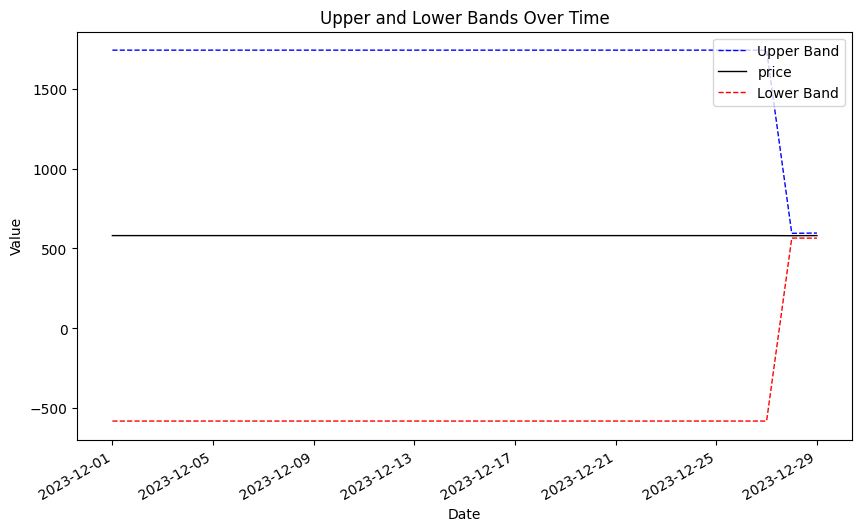

In [49]:
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制折线图
plt.plot(data['Date'], data['upperband'], marker='', color='blue', linewidth=1, linestyle='--', label='Upper Band')
plt.plot(data['Date'], data['ma'], marker='', color='black', linewidth=1, label='price')
plt.plot(data['Date'], data['lowerband'], marker='', color='red', linewidth=1, linestyle='--', label='Lower Band')

# 添加标题和标签
plt.title('Upper and Lower Bands Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 自动调整日期显示格式
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()

## K線圖

c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26681 (\N{CJK UNIFIED IDEOGRAPH-6839}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28072 (\N{CJK U

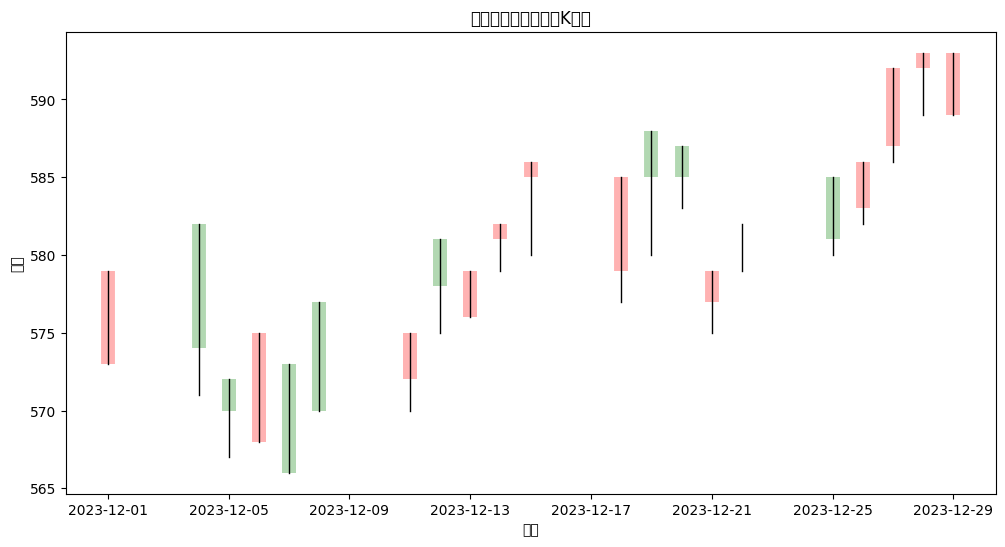

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# 将 Date 列转换为日期时间格式
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(12, 6))

# 绘制K线图
for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    close_price = row['Close']
    high_price = row['High']
    low_price = row['Low']
    
    if close_price >= open_price:
        # 涨：最高价 - 收盘价 和 开盘价 - 最低价 的填充为红色
        plt.fill([date, date, date], [high_price, close_price, open_price], 'red', edgecolor='red', linewidth=10, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)
    else:
        # 跌：最高价 - 开盘价 和 收盘价 - 最低价 的填充为绿色
        plt.fill([date, date, date], [high_price, open_price, close_price], 'green', edgecolor='green', linewidth=10, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)

# 设置x轴日期显示格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 添加标题和标签
plt.title('根据涨跌情况填充的K线图')
plt.xlabel('日期')
plt.ylabel('价格')

# 显示图形
plt.show()


In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 读取数据
data = pd.read_csv('data2023.csv')
data =data.iloc[20:].reset_index(drop=True)

c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK U

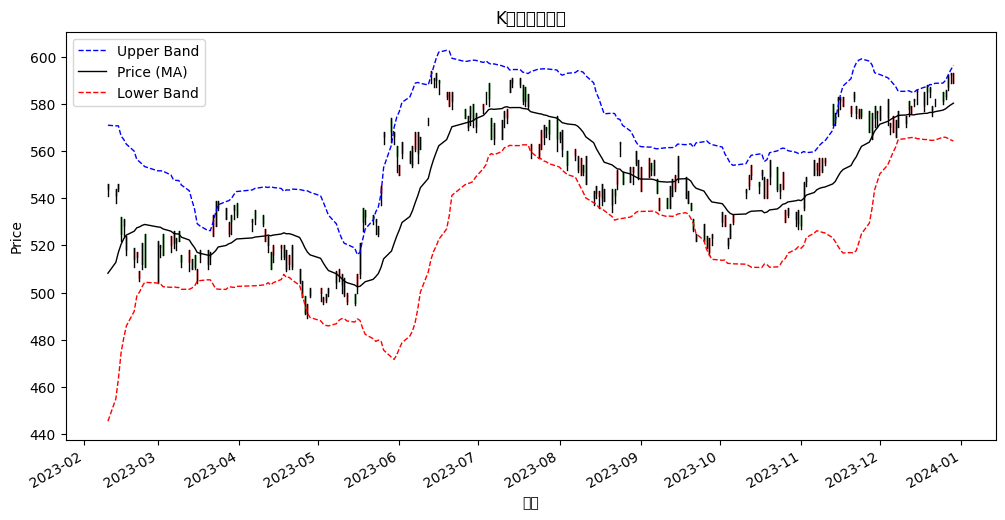

In [94]:


# 将 Date 列转换为日期时间格式
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(12, 6))

# 绘制K线图
for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    close_price = row['Close']
    high_price = row['High']
    low_price = row['Low']
    
    if close_price >= open_price:
        # 涨：最高价 - 收盘价 和 开盘价 - 最低价 的填充为红色
        plt.fill([date, date, date], [high_price, close_price, open_price], 'red', edgecolor='red', linewidth=2, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)
    else:
        # 跌：最高价 - 开盘价 和 收盘价 - 最低价 的填充为绿色
        plt.fill([date, date, date], [high_price, open_price, close_price], 'green', edgecolor='green', linewidth=2, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)

# 绘制折线图
plt.plot(data['Date'], data['upperband'], marker='', color='blue', linewidth=1, linestyle='--', label='Upper Band')
plt.plot(data['Date'], data['ma'], marker='', color='black', linewidth=1, label='Price (MA)')
plt.plot(data['Date'], data['lowerband'], marker='', color='red', linewidth=1, linestyle='--', label='Lower Band')

# 设置标题和标签
plt.title('K线图与折线图')
plt.xlabel('日期')
plt.ylabel('Price')

# 添加图例
plt.legend()

# 自动调整日期显示格式
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()